In [57]:
""" Simple GAN """
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# TASK 0
class Simple_GAN(keras.Model):
    """ Class Simple GAN """
    def __init__(self, generator, discriminator,
                 latent_generator, real_examples,
                 batch_size=200, disc_iter=2, learning_rate=.005):
        """ INIT """
        super().__init__()
        self.latent_generator = latent_generator
        self.real_examples = real_examples
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.disc_iter = disc_iter

        self.learning_rate = learning_rate
        self.beta_1 = .5
        self.beta_2 = .9

        # define the generator loss and optimizer:
        self.generator.loss = lambda x: \
            tf.keras.losses.MeanSquaredError()(x, tf.ones(x.shape))
        self.generator.optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate,
            beta_1=self.beta_1, beta_2=self.beta_2)
        self.generator.compile(optimizer=generator.optimizer,
                               loss=generator.loss)

        # define the discriminator loss and optimizer:
        self.discriminator.loss = lambda x, y: \
            tf.keras.losses.MeanSquaredError()(x, tf.ones(x.shape)) + \
            tf.keras.losses.MeanSquaredError()(y, -1*tf.ones(y.shape))
        self.discriminator.optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate,
            beta_1=self.beta_1, beta_2=self.beta_2)
        self.discriminator.compile(
            optimizer=discriminator.optimizer, loss=discriminator.loss)

    def get_fake_sample(self, size=None, training=False):
        """ generator of real samples of size batch_size"""
        if not size:
            size = self.batch_size
        return self.generator(self.latent_generator(size), training=training)

    def get_real_sample(self, size=None):
        """ generator of fake samples of size batch_size """
        if not size:
            size = self.batch_size
        sorted_indices = tf.range(tf.shape(self.real_examples)[0])
        random_indices = tf.random.shuffle(sorted_indices)[:size]
        return tf.gather(self.real_examples, random_indices)

    def train_step(self, useless_argument):
        """ overloading train_step()"""
        for _ in range(self.disc_iter):
            # Compute the loss for the discriminator in a
            # tape watching the discriminator's weights
            with tf.GradientTape() as disc_tape:
                real_sample = self.get_real_sample()
                fake_sample = self.get_fake_sample()
                disc_real_output = self.discriminator(
                    real_sample, training=True)
                disc_fake_output = self.discriminator(
                    fake_sample, training=True)
                discr_loss = self.discriminator.loss(
                    disc_real_output, disc_fake_output)

            # Apply gradient descent once to the discriminator
            disc_gradients = disc_tape.gradient(
                discr_loss, self.discriminator.trainable_variables)
            self.discriminator.optimizer.apply_gradients(
                zip(disc_gradients, self.discriminator.trainable_variables))

        # Compute the loss for the generator in
        # a tape watching the generator's weights
        with tf.GradientTape() as gen_tape:
            fake_sample = self.get_fake_sample()
            gen_output = self.discriminator(fake_sample, training=False)
            gen_loss = self.generator.loss(gen_output)

        # Apply gradient descent to the generator
        gen_gradients = gen_tape.gradient(
            gen_loss, self.generator.trainable_variables)
        self.generator.optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables))

        return {"discr_loss": discr_loss, "gen_loss": gen_loss}


MAIN 0

In [60]:
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def hash_tensor(tensor) :
    return np.sum(np.array([hash(x)%2**30 for x in tensor.numpy().flatten()]))%2**30


def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

circle_example = lambda k : spheric_generator(k, 2)*.3+.5

## LET'S GO !

set_seeds(0)
G=example_fully_connected_GAN(Simple_GAN,circle_example(1000), [1,10,10,2], 16, steps_per_epoch=100, learning_rate=.001)

Epoch 1/16
100/100 [==============================] - 3s 6ms/step - discr_loss: 2.0414 - gen_loss: 1.1100
Epoch 2/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9627 - gen_loss: 1.0197
Epoch 3/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9614 - gen_loss: 1.0231
Epoch 4/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9925 - gen_loss: 1.0188
Epoch 5/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9071 - gen_loss: 1.0597
Epoch 6/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9449 - gen_loss: 1.0523
Epoch 7/16
100/100 [==============================] - 1s 7ms/step - discr_loss: 1.9851 - gen_loss: 1.0132
Epoch 8/16
100/100 [==============================] - 1s 7ms/step - discr_loss: 1.9390 - gen_loss: 1.0371
Epoch 9/16
100/100 [==============================] - 1s 7ms/step - discr_loss: 1.8984 - gen_loss: 1.0652
Epoch 10/16
100/100 [=========================

Epoch 1/16
100/100 [==============================] - 3s 6ms/step - discr_loss: 2.0414 - gen_loss: 1.1100
Epoch 2/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9627 - gen_loss: 1.0197
Epoch 3/16
100/100 [==============================] - 1s 5ms/step - discr_loss: 1.9614 - gen_loss: 1.0231
Epoch 4/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9925 - gen_loss: 1.0188
Epoch 5/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9071 - gen_loss: 1.0597
Epoch 6/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9449 - gen_loss: 1.0523
Epoch 7/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9851 - gen_loss: 1.0132
Epoch 8/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.9390 - gen_loss: 1.0371
Epoch 9/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.8984 - gen_loss: 1.0652
Epoch 10/16
100/100 [=========================

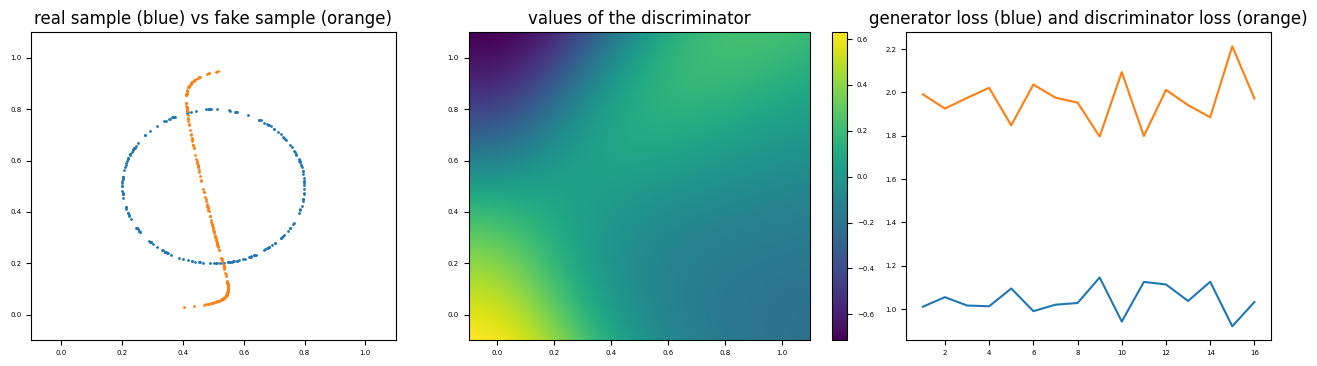

In [61]:
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def hash_tensor(tensor) :
    return np.sum(np.array([hash(x)%2**30 for x in tensor.numpy().flatten()]))%2**30


def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

circle_example = lambda k : spheric_generator(k, 2)*.3+.5

## Visualize 2D the result of G

def visualize_2D(G, show=True, title=None, filename=None, dpi=200):
    fig = plt.figure(figsize=(16, 4))
    wax = 6  # width of ax
    gs = gridspec.GridSpec(wax, wax * 3 + 2)
    axes = [fig.add_subplot(gs[:, :wax]),
            fig.add_subplot(gs[:, wax + 1:2 * wax + 2]),
            fig.add_subplot(gs[:, 2 * wax + 2:])]

    # draw a real and a fake sample on axis 0:
    axes[0].set_xlim(-.1, 1.1)
    axes[0].set_ylim(-.1, 1.1)

    X = G.get_real_sample(size=200).numpy()
    axes[0].scatter(X[:, 0], X[:, 1], s=1)

    X = G.get_fake_sample(size=200).numpy()
    axes[0].scatter(X[:, 0], X[:, 1], s=1)

    axes[0].set_title("real sample (blue) vs fake sample (orange)")

    # draw the values of the discriminator on [-1,1]x[-1,1] on axis 1:
    axes[1].set_xlim(-.1, 1.1)
    axes[1].set_ylim(-.1, 1.1)

    A = np.linspace(-.1, 1.1, 150)
    B = np.linspace(-.1, 1.1, 150)
    X, Y = np.meshgrid(A, B)
    U = tf.convert_to_tensor(np.vstack([X.ravel(), Y.ravel()]).T)

    X = G.discriminator(U, training=False).numpy()
    u = axes[1].pcolormesh(A, B, X[:, 0].reshape([150, 150]), shading='gouraud')

    axes[1].set_title("values of the discriminator")

    sci = lambda x: "{:.2E}".format(.99 * x * (x > 0) + 1.01 * x * (x < 0))
    cb = fig.colorbar(u, ax=axes[1])
    # cb.set_ticks([sci(np.min(X[:,0])), 0, sci(np.max(X[:,0]))])
    cb.ax.tick_params(labelsize=5)

    # draw the training history on axis 3:
    HGL = G.history.history["gen_loss"]
    HDL = G.history.history["discr_loss"]

    axes[2].plot(np.arange(1, len(HGL) + 1), HGL)
    axes[2].plot(np.arange(1, len(HGL) + 1), HDL)
    axes[2].set_title("generator loss (blue) and discriminator loss (orange)")

    # some more tuning:
    for a in axes:
        a.tick_params(axis='both', which='major', labelsize=5)
        a.tick_params(axis='both', which='minor', labelsize=5)

    if title:
        fig.suptitle(title)

    if filename:
        plt.savefig(filename, dpi=dpi)
        plt.close()

    if show:
        plt.show()

## LET'S GO !

set_seeds(0)
G=example_fully_connected_GAN(Simple_GAN,circle_example(1000), [1,10,10,2], 16, steps_per_epoch=100, learning_rate=.001)
visualize_2D(G)


Epoch 1/16
100/100 [==============================] - 3s 6ms/step - discr_loss: 1.6356 - gen_loss: 1.4212
Epoch 2/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.7100 - gen_loss: 1.3046
Epoch 3/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.3549 - gen_loss: 1.5677
Epoch 4/16
100/100 [==============================] - 1s 5ms/step - discr_loss: 1.2818 - gen_loss: 1.6193
Epoch 5/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.2233 - gen_loss: 1.7302
Epoch 6/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.2361 - gen_loss: 1.8286
Epoch 7/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.2872 - gen_loss: 1.8375
Epoch 8/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.3983 - gen_loss: 1.7318
Epoch 9/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 1.5846 - gen_loss: 1.5048
Epoch 10/16
100/100 [=========================

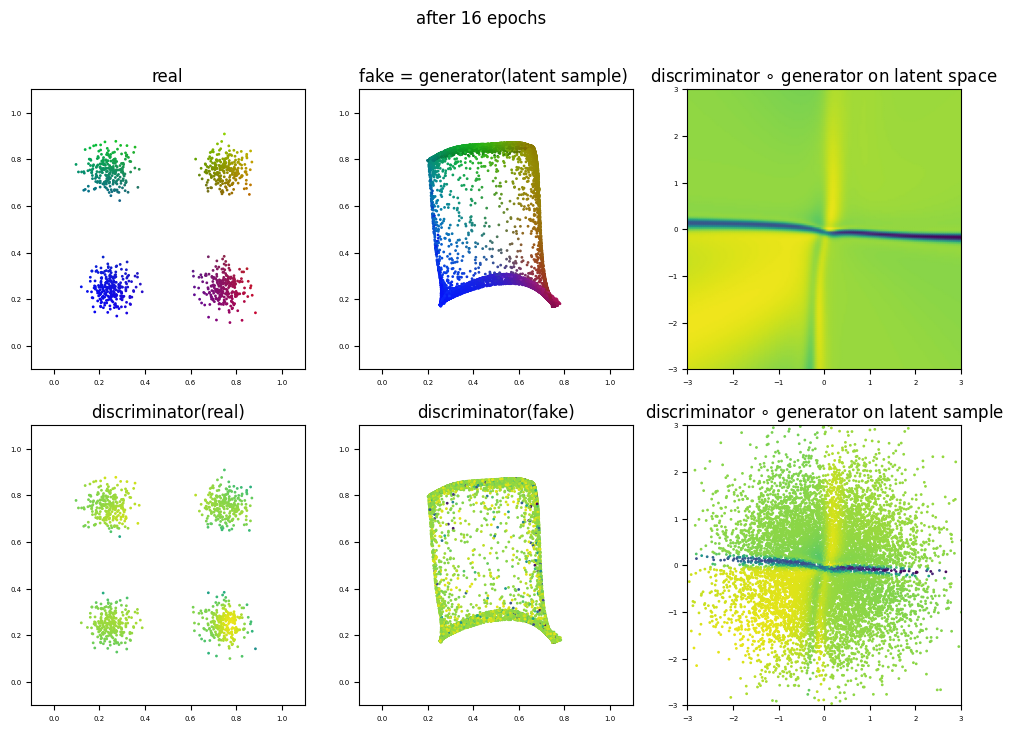

In [62]:
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def hash_tensor(tensor) :
    return np.sum(np.array([hash(x)%2**30 for x in tensor.numpy().flatten()]))%2**30


def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

def four_clouds_example(N_real):
    X   = np.random.randn( N_real)*.05
    Y   = np.random.randn( N_real)*.05
    X[:N_real//2]+=.75
    X[N_real//2:]+=.25
    Y[N_real//4:N_real//2]+=.25
    Y[:N_real//4]+=.75
    Y[N_real//2:3*N_real//4]+=.75
    Y[3*N_real//4:]+=.25
    R   = np.minimum(X*X,1)
    G   = np.minimum(Y*Y,1)
    B   = np.maximum(1-R-G,0)
    return tf.convert_to_tensor(np.vstack([X,Y,R,G,B]).T)

## Visualize 5D the result of G

def visualize_5D(G, show=True, title=None, filename=None, dpi=200):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for ax in axes.flatten():
        ax.set_xlim(-.1, 1.1)
        ax.set_ylim(-.1, 1.1)

    X_tf = G.real_examples
    X = X_tf.numpy()
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=X[:, 2:], s=1)
    axes[0, 0].set_title("real")

    lat = G.latent_generator(10000)
    Y_tf = G.generator(lat)
    Y = Y_tf.numpy()
    axes[0, 1].scatter(Y[:, 0], Y[:, 1], c=Y[:, 2:], s=1)
    axes[0, 1].set_title("fake = generator(latent sample) ")

    cX = G.discriminator(X_tf).numpy()
    cY = G.discriminator(Y_tf).numpy()
    m = min(np.min(cX), np.min(cY))
    M = max(np.max(cX), np.max(cY))

    axes[1, 0].scatter(X[:, 0], X[:, 1], c=cX, s=1, vmin=m, vmax=M)
    axes[1, 0].set_title("discriminator(real)")

    Y = G.generator(G.latent_generator(10000)).numpy()
    axes[1, 1].scatter(Y[:, 0], Y[:, 1], c=cY, s=1, vmin=m, vmax=M)
    axes[1, 1].set_title("discriminator(fake)")

    for i in range(2):
        axes[i, 2].set_xlim(-3, 3)
        axes[i, 2].set_ylim(-3, 3)

    A = np.linspace(-3, 3, 150)
    B = np.linspace(-3, 3, 150)
    X, Y = np.meshgrid(A, B)
    U = tf.convert_to_tensor(np.vstack([X.ravel(), Y.ravel()]).T)

    X = G.discriminator(G.generator(U)).numpy()
    u = axes[0, 2].pcolormesh(A, B, X[:, 0].reshape([150, 150]), shading='gouraud')

    axes[0, 2].set_title(r"discriminator $\circ$ generator on latent space")

    axes[1, 2].scatter(lat.numpy()[:, 0], lat.numpy()[:, 1], c=cY, s=1)
    axes[1, 2].set_title(r"discriminator $\circ$ generator on latent sample")
    # sci = lambda x : "{:.2E}".format(.99*x*(x>0)+1.01*x*(x<0))
    # cb=fig.colorbar(u, ax=axes[1])
    ##cb.set_ticks([sci(np.min(X[:,0])), 0, sci(np.max(X[:,0]))])
    # cb.ax.tick_params(labelsize=5)

    # some more tuning:
    for a in axes.flatten():
        a.tick_params(axis='both', which='major', labelsize=5)
        a.tick_params(axis='both', which='minor', labelsize=5)

    if title:
        fig.suptitle(title)

    if filename:
        plt.savefig(filename, dpi=dpi)
        if show:
            plt.show()
        plt.close()

    elif show:
        plt.show()

## LET'S GO !

set_seeds(0)
G = example_fully_connected_GAN(Simple_GAN ,four_clouds_example(1000), [2,10,10,5], 16, steps_per_epoch=100, learning_rate=.001)
visualize_5D(G,show=True, title=f"after 16 epochs")

In [63]:
# TASK 1

class WGAN_clip(keras.Model):

    def __init__(self, generator, discriminator, latent_generator, real_examples, batch_size=200, disc_iter=2, learning_rate=.005):
        super().__init__()  # run the __init__ of keras.Model first.
        self.latent_generator = latent_generator
        self.real_examples = real_examples
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.disc_iter = disc_iter

        self.learning_rate = learning_rate
        self.beta_1 = .5  # standard value, but can be changed if necessary
        self.beta_2 = .9  # standard value, but can be changed if necessary

        # define the generator loss and optimizer:
        self.generator.loss = self.generator_loss
        self.generator.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.generator.compile(optimizer=self.generator.optimizer, loss=self.generator.loss)

        # define the discriminator loss and optimizer:
        self.discriminator.loss = self.discriminator_loss
        self.discriminator.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.discriminator.compile(optimizer=self.discriminator.optimizer, loss=self.discriminator.loss)

    # generator of real samples of size batch_size
    def get_fake_sample(self, size=None, training=False):
        if not size:
            size = self.batch_size
        return self.generator(self.latent_generator(size), training=training)

    # generator of fake samples of size batch_size
    def get_real_sample(self, size=None):
        if not size:
            size = self.batch_size
        sorted_indices = tf.range(tf.shape(self.real_examples)[0])
        random_indices = tf.random.shuffle(sorted_indices)[:size]
        return tf.gather(self.real_examples, random_indices)

    def generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)

    def discriminator_loss(self, real_output, fake_output):
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # overloading train_step()
    def train_step(self, useless_argument):
        for _ in range(self.disc_iter):
            with tf.GradientTape() as disc_tape:
                real_samples = self.get_real_sample()
                fake_samples = self.get_fake_sample(training=True)
                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)
                discr_loss = self.discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)
            self.discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

            # Clip discriminator weights
            for var in self.discriminator.trainable_variables:
                var.assign(tf.clip_by_value(var, -1.0, 1.0))

        with tf.GradientTape() as gen_tape:
            fake_samples = self.get_fake_sample(training=True)
            fake_output = self.discriminator(fake_samples, training=True)
            gen_loss = self.generator_loss(fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return {"discr_loss": discr_loss, "gen_loss": gen_loss}


Epoch 1/16
100/100 [==============================] - 3s 7ms/step - discr_loss: -0.4349 - gen_loss: 0.7395
Epoch 2/16
100/100 [==============================] - 1s 7ms/step - discr_loss: -0.6472 - gen_loss: 0.8367
Epoch 3/16
100/100 [==============================] - 1s 7ms/step - discr_loss: -0.4737 - gen_loss: 0.8873
Epoch 4/16
100/100 [==============================] - 1s 7ms/step - discr_loss: -0.2556 - gen_loss: 0.9439
Epoch 5/16
100/100 [==============================] - 1s 6ms/step - discr_loss: -0.0014 - gen_loss: 0.9927
Epoch 6/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 3.5173e-07 - gen_loss: 1.0000
Epoch 7/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 0.0000e+00 - gen_loss: 1.0000
Epoch 8/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 0.0000e+00 - gen_loss: 1.0000
Epoch 9/16
100/100 [==============================] - 1s 6ms/step - discr_loss: 0.0000e+00 - gen_loss: 1.0000
Epoch 10/16
100/100 [====

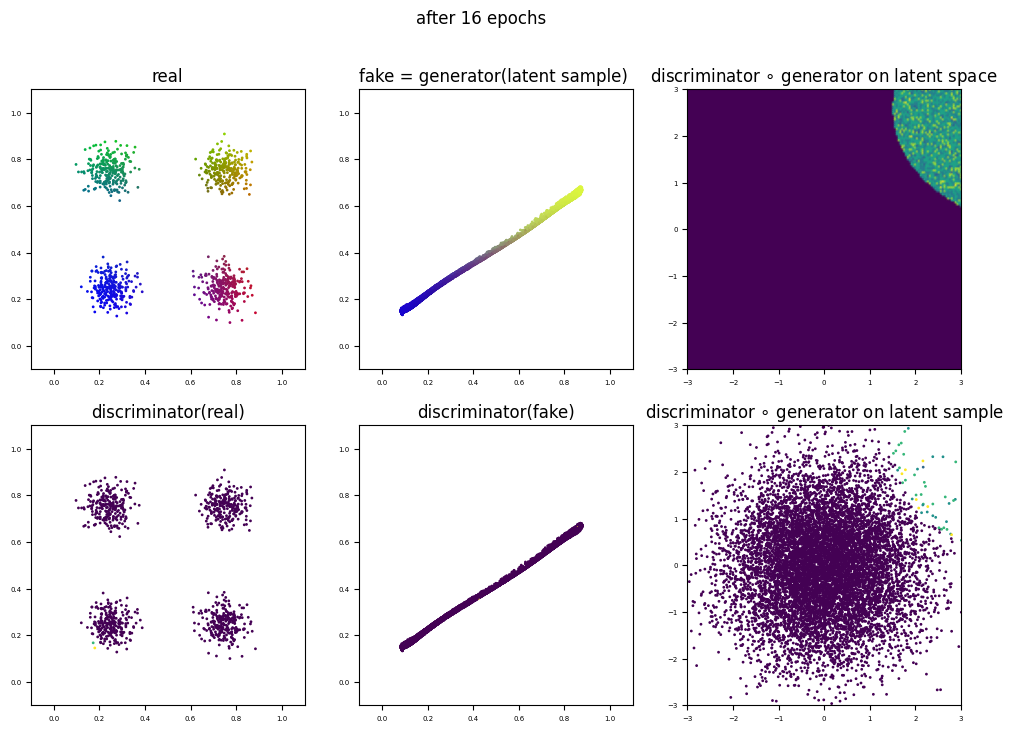

In [64]:
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def hash_tensor(tensor) :
    return np.sum(np.array([hash(x)%2**30 for x in tensor.numpy().flatten()]))%2**30


def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

def four_clouds_example(N_real):
    X   = np.random.randn( N_real)*.05
    Y   = np.random.randn( N_real)*.05
    X[:N_real//2]+=.75
    X[N_real//2:]+=.25
    Y[N_real//4:N_real//2]+=.25
    Y[:N_real//4]+=.75
    Y[N_real//2:3*N_real//4]+=.75
    Y[3*N_real//4:]+=.25
    R   = np.minimum(X*X,1)
    G   = np.minimum(Y*Y,1)
    B   = np.maximum(1-R-G,0)
    return tf.convert_to_tensor(np.vstack([X,Y,R,G,B]).T)


## Visualize 5D the result of G

def visualize_5D(G, show=True, title=None, filename=None, dpi=200):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for ax in axes.flatten():
        ax.set_xlim(-.1, 1.1)
        ax.set_ylim(-.1, 1.1)

    X_tf = G.real_examples
    X = X_tf.numpy()
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=X[:, 2:], s=1)
    axes[0, 0].set_title("real")

    lat = G.latent_generator(10000)
    Y_tf = G.generator(lat)
    Y = Y_tf.numpy()
    axes[0, 1].scatter(Y[:, 0], Y[:, 1], c=Y[:, 2:], s=1)
    axes[0, 1].set_title("fake = generator(latent sample) ")

    cX = G.discriminator(X_tf).numpy()
    cY = G.discriminator(Y_tf).numpy()
    m = min(np.min(cX), np.min(cY))
    M = max(np.max(cX), np.max(cY))

    axes[1, 0].scatter(X[:, 0], X[:, 1], c=cX, s=1, vmin=m, vmax=M)
    axes[1, 0].set_title("discriminator(real)")

    Y = G.generator(G.latent_generator(10000)).numpy()
    axes[1, 1].scatter(Y[:, 0], Y[:, 1], c=cY, s=1, vmin=m, vmax=M)
    axes[1, 1].set_title("discriminator(fake)")

    for i in range(2):
        axes[i, 2].set_xlim(-3, 3)
        axes[i, 2].set_ylim(-3, 3)

    A = np.linspace(-3, 3, 150)
    B = np.linspace(-3, 3, 150)
    X, Y = np.meshgrid(A, B)
    U = tf.convert_to_tensor(np.vstack([X.ravel(), Y.ravel()]).T)

    X = G.discriminator(G.generator(U)).numpy()
    u = axes[0, 2].pcolormesh(A, B, X[:, 0].reshape([150, 150]), shading='gouraud')

    axes[0, 2].set_title(r"discriminator $\circ$ generator on latent space")

    axes[1, 2].scatter(lat.numpy()[:, 0], lat.numpy()[:, 1], c=cY, s=1)
    axes[1, 2].set_title(r"discriminator $\circ$ generator on latent sample")
    # sci = lambda x : "{:.2E}".format(.99*x*(x>0)+1.01*x*(x<0))
    # cb=fig.colorbar(u, ax=axes[1])
    ##cb.set_ticks([sci(np.min(X[:,0])), 0, sci(np.max(X[:,0]))])
    # cb.ax.tick_params(labelsize=5)

    # some more tuning:
    for a in axes.flatten():
        a.tick_params(axis='both', which='major', labelsize=5)
        a.tick_params(axis='both', which='minor', labelsize=5)

    if title:
        fig.suptitle(title)

    if filename:
        plt.savefig(filename, dpi=dpi)
        if show:
            plt.show()
        plt.close()

    elif show:
        plt.show()

## LET'S GO !

set_seeds(0)
G = example_fully_connected_GAN(WGAN_clip ,four_clouds_example(1000), [2,10,10,5], 16, steps_per_epoch=100, learning_rate=.001)
visualize_5D(G,show=True, title=f"after 16 epochs")

In [65]:
# TASK 2

class WGAN_GP(keras.Model):
    def __init__(self, generator, discriminator, latent_generator, real_examples, batch_size=200, disc_iter=2, learning_rate=.005, lambda_gp=10):
        super().__init__()  # run the __init__ of keras.Model first.
        self.latent_generator = latent_generator
        self.real_examples = real_examples
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.disc_iter = disc_iter

        self.learning_rate = learning_rate
        self.beta_1 = .3  # standard value, but can be changed if necessary
        self.beta_2 = .9  # standard value, but can be changed if necessary

        self.lambda_gp = lambda_gp  # <---- New !
        self.dims = self.real_examples.shape  # <---- New !
        self.len_dims = tf.size(self.dims)  # <---- New !
        self.axis = tf.range(1, self.len_dims, delta=1, dtype='int32')  # <---- New !
        self.scal_shape = self.dims.as_list()  # <---- New !
        self.scal_shape[0] = self.batch_size  # <---- New !
        for i in range(1, self.len_dims):  # <---- New !
            self.scal_shape[i] = 1  # <---- New !
        self.scal_shape = tf.convert_to_tensor(self.scal_shape)  # <---- New !

        # define the generator loss and optimizer:
        self.generator.loss = self.generator_loss  # <---- to be filled in
        self.generator.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.generator.compile(optimizer=self.generator.optimizer, loss=self.generator.loss)

        # define the discriminator loss and optimizer:
        self.discriminator.loss = self.discriminator_loss  # <---- to be filled in
        self.discriminator.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.discriminator.compile(optimizer=self.discriminator.optimizer, loss=self.discriminator.loss)

    # generator of real samples of size batch_size
    def get_fake_sample(self, size=None, training=False):
        if not size:
            size = self.batch_size
        return self.generator(self.latent_generator(size), training=training)

    # generator of fake samples of size batch_size
    def get_real_sample(self, size=None):
        if not size:
            size = self.batch_size
        sorted_indices = tf.range(tf.shape(self.real_examples)[0])
        random_indices = tf.random.shuffle(sorted_indices)[:size]
        return tf.gather(self.real_examples, random_indices)

    # generator of interpolating samples of size batch_size              # <---- New !
    def get_interpolated_sample(self, real_sample, fake_sample):
        u = tf.random.uniform(self.scal_shape)
        v = tf.ones(self.scal_shape) - u
        return u * real_sample + v * fake_sample

    # computing the gradient penalty                                     # <---- New !
    def gradient_penalty(self, interpolated_sample):
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_sample)
            pred = self.discriminator(interpolated_sample, training=True)
        grads = gp_tape.gradient(pred, [interpolated_sample])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=self.axis))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)

    def discriminator_loss(self, real_output, fake_output):
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # overloading train_step()
    def train_step(self, useless_argument):
        for _ in range(self.disc_iter):
            with tf.GradientTape() as disc_tape:
                real_samples = self.get_real_sample()
                fake_samples = self.get_fake_sample(training=True)
                interpolated_samples = self.get_interpolated_sample(real_samples, fake_samples)

                real_output = self.discriminator(real_samples, training=True)
                fake_output = self.discriminator(fake_samples, training=True)
                inter_output = self.discriminator(interpolated_samples, training=True)

                discr_loss = self.discriminator_loss(real_output, fake_output)
                gp = self.gradient_penalty(interpolated_samples)
                new_discr_loss = discr_loss + self.lambda_gp * gp

            gradients_of_discriminator = disc_tape.gradient(new_discr_loss, self.discriminator.trainable_variables)
            self.discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:
            fake_samples = self.get_fake_sample(training=True)
            fake_output = self.discriminator(fake_samples, training=True)
            gen_loss = self.generator_loss(fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return {"discr_loss": discr_loss, "gen_loss": gen_loss, "gp": gp}


Epoch 1/16
100/100 [==============================] - 4s 7ms/step - discr_loss: -0.1232 - gen_loss: 0.1223 - gp: 0.0066
Epoch 2/16
100/100 [==============================] - 1s 8ms/step - discr_loss: -0.1310 - gen_loss: 4.7358e-04 - gp: 0.0011
Epoch 3/16
100/100 [==============================] - 1s 8ms/step - discr_loss: -0.0183 - gen_loss: -0.2039 - gp: 0.0038
Epoch 4/16
100/100 [==============================] - 1s 12ms/step - discr_loss: -0.1799 - gen_loss: -0.1863 - gp: 0.0049
Epoch 5/16
100/100 [==============================] - 1s 9ms/step - discr_loss: -0.2660 - gen_loss: 0.0200 - gp: 0.0039
Epoch 6/16
100/100 [==============================] - 1s 8ms/step - discr_loss: -0.1196 - gen_loss: -0.1207 - gp: 0.0058
Epoch 7/16
100/100 [==============================] - 1s 8ms/step - discr_loss: -0.2367 - gen_loss: -0.1063 - gp: 0.0064
Epoch 8/16
100/100 [==============================] - 1s 8ms/step - discr_loss: -0.2150 - gen_loss: -0.0373 - gp: 0.0045
Epoch 9/16
100/100 [==========

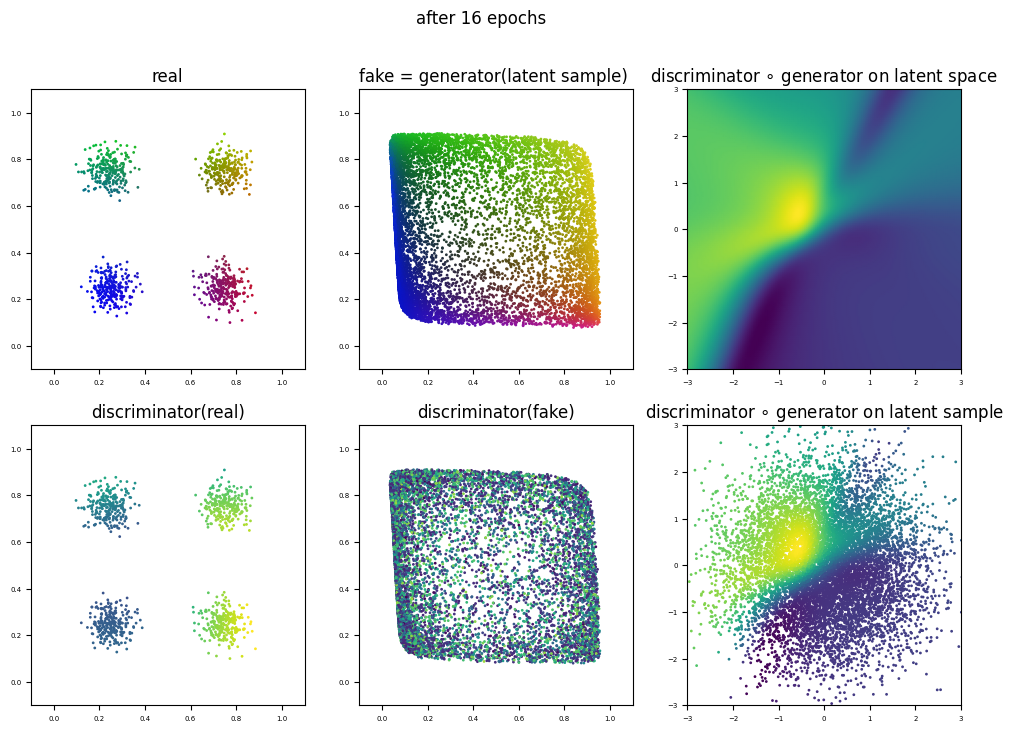

In [66]:
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

def four_clouds_example(N_real):
    X   = np.random.randn( N_real)*.05
    Y   = np.random.randn( N_real)*.05
    X[:N_real//2]+=.75
    X[N_real//2:]+=.25
    Y[N_real//4:N_real//2]+=.25
    Y[:N_real//4]+=.75
    Y[N_real//2:3*N_real//4]+=.75
    Y[3*N_real//4:]+=.25
    R   = np.minimum(X*X,1)
    G   = np.minimum(Y*Y,1)
    B   = np.maximum(1-R-G,0)
    return tf.convert_to_tensor(np.vstack([X,Y,R,G,B]).T,dtype="float32")


## Visualize 5D the result of G

def visualize_5D(G, show=True, title=None, filename=None, dpi=200):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for ax in axes.flatten():
        ax.set_xlim(-.1, 1.1)
        ax.set_ylim(-.1, 1.1)

    X_tf = G.real_examples
    X = X_tf.numpy()
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=X[:, 2:], s=1)
    axes[0, 0].set_title("real")

    lat = G.latent_generator(10000)
    Y_tf = G.generator(lat)
    Y = Y_tf.numpy()
    axes[0, 1].scatter(Y[:, 0], Y[:, 1], c=Y[:, 2:], s=1)
    axes[0, 1].set_title("fake = generator(latent sample) ")

    cX = G.discriminator(X_tf).numpy()
    cY = G.discriminator(Y_tf).numpy()
    m = min(np.min(cX), np.min(cY))
    M = max(np.max(cX), np.max(cY))

    axes[1, 0].scatter(X[:, 0], X[:, 1], c=cX, s=1, vmin=m, vmax=M)
    axes[1, 0].set_title("discriminator(real)")

    Y = G.generator(G.latent_generator(10000)).numpy()
    axes[1, 1].scatter(Y[:, 0], Y[:, 1], c=cY, s=1, vmin=m, vmax=M)
    axes[1, 1].set_title("discriminator(fake)")

    for i in range(2):
        axes[i, 2].set_xlim(-3, 3)
        axes[i, 2].set_ylim(-3, 3)

    A = np.linspace(-3, 3, 150)
    B = np.linspace(-3, 3, 150)
    X, Y = np.meshgrid(A, B)
    U = tf.convert_to_tensor(np.vstack([X.ravel(), Y.ravel()]).T)

    X = G.discriminator(G.generator(U)).numpy()
    u = axes[0, 2].pcolormesh(A, B, X[:, 0].reshape([150, 150]), shading='gouraud')

    axes[0, 2].set_title(r"discriminator $\circ$ generator on latent space")

    axes[1, 2].scatter(lat.numpy()[:, 0], lat.numpy()[:, 1], c=cY, s=1)
    axes[1, 2].set_title(r"discriminator $\circ$ generator on latent sample")
    # sci = lambda x : "{:.2E}".format(.99*x*(x>0)+1.01*x*(x<0))
    # cb=fig.colorbar(u, ax=axes[1])
    ##cb.set_ticks([sci(np.min(X[:,0])), 0, sci(np.max(X[:,0]))])
    # cb.ax.tick_params(labelsize=5)

    # some more tuning:
    for a in axes.flatten():
        a.tick_params(axis='both', which='major', labelsize=5)
        a.tick_params(axis='both', which='minor', labelsize=5)

    if title:
        fig.suptitle(title)

    if filename:
        plt.savefig(filename, dpi=dpi)
        if show:
            plt.show()
        plt.close()

    elif show:
        plt.show()

## LET'S GO !

set_seeds(0)
G = example_fully_connected_GAN(WGAN_GP ,four_clouds_example(1000), [2,10,10,5], 16, steps_per_epoch=100, learning_rate=.001)
visualize_5D(G,show=True, title=f"after 16 epochs")

In [67]:
def cloud_in_the_corner_numpy(N,sigma,S) :
    arr=np.random.randn(S*N).reshape(S,N)
    return arr*sigma+.8

def cloud_in_the_corner(C,sigma,S) :
    return tf.convert_to_tensor(cloud_in_the_corner_numpy(C,sigma,S),dtype="float32")

Among 10000 clouds of 100 points, the distribution of the mean squared distance
          from the points of the cloud to the center has the following shape :


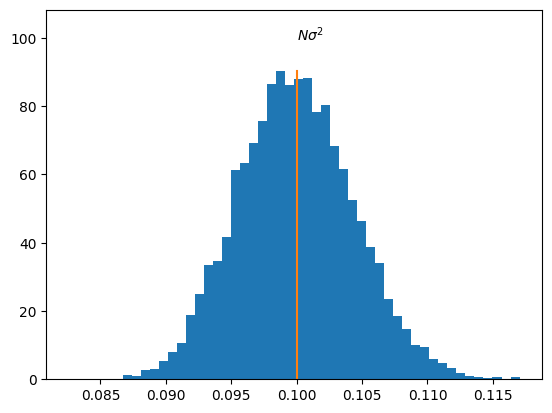

In [68]:
def mean_squared_dist_cloud_to_center(cloud) :
    return np.mean((np.sum(np.square(cloud-.8),axis=1)))

def expected_mean_squared_dist_cloud_to_center(N,sigma,S):
    return sigma*sigma*N

def verif_mean_squared_dist_cloud_to_center(N,sigma,S) :
    mean_squared_dists=[]
    for i in range(10000) :
        cloud=cloud_in_the_corner_numpy(N,sigma,S)
        mean_squared_dists.append(mean_squared_dist_cloud_to_center(cloud))
    print(f"""Among 10000 clouds of {S} points, the distribution of the mean squared distance
          from the points of the cloud to the center has the following shape :""")
    a=plt.hist(mean_squared_dists,bins=50,density=True)
    expected = expected_mean_squared_dist_cloud_to_center(N,sigma,S)
    plt.plot([expected,expected],[0,np.max(a[0])])
    plt.text(expected, np.max(a[0])*1.1, r'$N\sigma^2$', dict(size=10))
    plt.ylim(0,np.max(a[0])*1.2)
    plt.show()

np.random.seed(0)
verif_mean_squared_dist_cloud_to_center(10,.1,100)

Among 10000 clouds of 100 points, the distribution of the squared distance
          from the barycenter of the cloud to the center has the following shape :


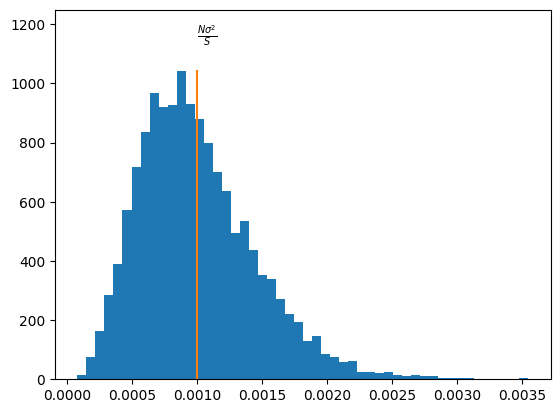

In [69]:
def squared_dist_barycenter_to_center(cloud) :
    S=cloud.shape[0]
    N=cloud.shape[1]
    barycenter = 1/S*np.sum(cloud,axis=0)
    diff= barycenter - .8
    return np.sum(np.square(diff))

def expected_squared_dist_barycenter_to_center(N,sigma,S) :
    return sigma*sigma*N/S

def verif_squared_dist_barycenter_to_center(N,sigma,S) :
    squared_dists=[]
    for i in range(10000) :
        cloud=cloud_in_the_corner_numpy(N,sigma,S)
        squared_dists.append(squared_dist_barycenter_to_center(cloud))
    print(f"""Among 10000 clouds of {S} points, the distribution of the squared distance
          from the barycenter of the cloud to the center has the following shape :""")
    a=plt.hist(squared_dists,bins=50,density=True)
    expected = expected_squared_dist_barycenter_to_center(N,sigma,S)
    plt.plot([expected,expected],[0,np.max(a[0])])
    plt.text(expected, np.max(a[0])*1.1, r'$\frac{N\sigma^2}{S}$', dict(size=10))
    plt.ylim(0,np.max(a[0])*1.2)
    plt.show()

np.random.seed(0)
verif_squared_dist_barycenter_to_center(10,.1,100)

Epoch 1/100
250/250 [==============================] - 4s 6ms/step - discr_loss: 1.0074 - gen_loss: 1.5990
Epoch 2/100
250/250 [==============================] - 2s 6ms/step - discr_loss: 0.1114 - gen_loss: 3.1881
Epoch 3/100
250/250 [==============================] - 2s 7ms/step - discr_loss: 0.0229 - gen_loss: 3.7715
Epoch 4/100
250/250 [==============================] - 2s 7ms/step - discr_loss: 0.0743 - gen_loss: 3.7586
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - discr_loss: 0.3179 - gen_loss: 3.4417
Epoch 6/100
250/250 [==============================] - 1s 6ms/step - discr_loss: 0.7882 - gen_loss: 2.9790
Epoch 7/100
250/250 [==============================] - 1s 6ms/step - discr_loss: 1.2556 - gen_loss: 2.5447
Epoch 8/100
250/250 [==============================] - 1s 6ms/step - discr_loss: 1.5940 - gen_loss: 2.2989
Epoch 9/100
250/250 [==============================] - 1s 6ms/step - discr_loss: 1.7690 - gen_loss: 2.1122
Epoch 10/100
250/250 [===============

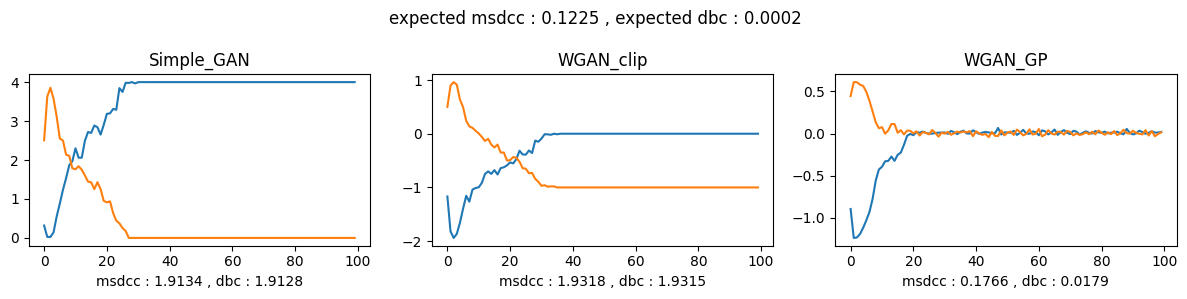

In [70]:
N=49
sigma=.05
shape=[N, 2*N , 2*N , N]
lr=.00003
S=500

## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))

def uniform_generator(nb_points, dim) :
    return tf.random.uniform(shape=(nb_points, dim))


## Code taken from above examples
def cloud_in_the_corner_numpy(N,sigma,S) :
    arr=np.random.randn(S*N).reshape(S,N)
    return arr*sigma+.8

def cloud_in_the_corner(C,sigma,S) :
    return tf.convert_to_tensor(cloud_in_the_corner_numpy(C,sigma,S),dtype="float32")

def mean_squared_dist_cloud_to_center(cloud) :
    return np.mean((np.sum(np.square(cloud-.8),axis=1)))

def expected_mean_squared_dist_cloud_to_center(N,sigma,S):
    return sigma*sigma*N
def squared_dist_barycenter_to_center(cloud) :
    S=cloud.shape[0]
    N=cloud.shape[1]
    barycenter = 1/S*np.sum(cloud,axis=0)
    diff= barycenter - .8
    return np.sum(np.square(diff))
def expected_squared_dist_barycenter_to_center(N,sigma,S) :
    return sigma*sigma*N/S

def verif_squared_dist_barycenter_to_center(N,sigma,S) :
    squared_dists=[]
    for i in range(10000) :
        cloud=cloud_in_the_corner_numpy(N,sigma,S)
        squared_dists.append(squared_dist_barycenter_to_center(cloud))
    print(f"""Among 10000 clouds of {S} points, the distribution of the squared distance
          from the barycenter of the cloud to the center has the following shape :""")
    a=plt.hist(squared_dists,bins=50,density=True)
    expected = expected_squared_dist_barycenter_to_center(N,sigma,S)
    plt.plot([expected,expected],[0,np.max(a[0])])
    plt.text(expected, np.max(a[0])*1.1, r'$\frac{N\sigma^2}{S}$', dict(size=10))
    plt.ylim(0,np.max(a[0])*1.2)
    plt.show()

## Building Generator and Discriminator

def fully_connected_GenDiscr(gen_shape, real_examples, latent_type="normal" ) :

    #   Latent generator
    if latent_type   == "uniform" :
        latent_generator  =  lambda k : uniform_generator(k,gen_shape[0])
    elif latent_type == "normal" :
        latent_generator  =  lambda k : normal_generator(k,gen_shape[0])
    elif latent_type == "spheric" :
        latent_generator  =  lambda k : spheric_generator(k,gen_shape[0])

    #   Generator
    inputs     = keras.Input(shape=( gen_shape[0] , ))
    hidden     = keras.layers.Dense( gen_shape[1] , activation = 'tanh'    )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden = keras.layers.Dense( gen_shape[i] , activation = 'tanh'    )(hidden)
    outputs    = keras.layers.Dense( gen_shape[-1], activation = 'sigmoid' )(hidden)
    generator  = keras.Model(inputs, outputs, name="generator")

    #   Discriminator
    inputs        = keras.Input(shape=( gen_shape[-1], ))
    hidden        = keras.layers.Dense( gen_shape[-2],   activation = 'tanh' )(inputs)
    for i in range(2,len(gen_shape)-1) :
        hidden    = keras.layers.Dense( gen_shape[-1*i], activation = 'tanh' )(hidden)
    outputs       = keras.layers.Dense( 1 ,              activation = 'tanh' )(hidden)
    discriminator = keras.Model(inputs, outputs, name="discriminator")

    return generator, discriminator, latent_generator

# illustration:
def illustr_fully_connected_GenDiscr() :
    generator, discriminator, latent_generator = fully_connected_GenDiscr([1,100,100,2], None)
    print(generator.summary())
    print(discriminator.summary())


## Training a fully connected GAN (Simple GAN)

def example_fully_connected_GAN(chosen_type ,real_examples, gen_shape, epochs,  batch_size=200, steps_per_epoch=250, latent_type="normal", learning_rate=.005):
    generator, discriminator, latent_generator = fully_connected_GenDiscr(gen_shape, real_examples, latent_type=latent_type )
    G=chosen_type( generator , discriminator , latent_generator, real_examples, learning_rate=learning_rate)
    G.compile()
    G.fit(real_examples, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
    return G


## An example of a large real sample

real=cloud_in_the_corner(N,sigma,10000)


## LET'S GO !

set_seeds(0)
Gs=[example_fully_connected_GAN(chosen_type, real, shape, 100, learning_rate=lr) for chosen_type in [Simple_GAN, WGAN_clip, WGAN_GP]]

## Plotting
fig,axes = plt.subplots(1,3,figsize=(12,3))
names=["Simple_GAN","WGAN_clip","WGAN_GP"]
from math import sqrt
for G,i,name in zip(Gs, range(3),names) :
    axes[i].plot(G.history.history["discr_loss"])
    axes[i].plot(G.history.history["gen_loss"])
    axes[i].set_title(name)
    cloud=G.get_fake_sample(S).numpy()
    fmsdcc = mean_squared_dist_cloud_to_center(cloud)
    fdbc   = squared_dist_barycenter_to_center(cloud)
    expected_msdcc = expected_mean_squared_dist_cloud_to_center(N,sigma,S)
    expected_dbc = expected_squared_dist_barycenter_to_center(N,sigma,S)
    axes[i].set_xlabel("msdcc : {:.4f} , dbc : {:.4f}".format(fmsdcc,fdbc))
fig.suptitle("expected msdcc : {:.4f} , expected dbc : {:.4f}".format( expected_msdcc , expected_dbc ))
plt.tight_layout()
plt.savefig("tests.png")
plt.show()

**3. Generating faces **

Here we will convince ourselves that gans can be trained into generators of faces. In order to do so, we first need a large enough sample of real faces.
Real faces

A sample of 10000 pictures of real faces is available in the file small_res_faces_10000.npy. Each of these is a greyscale 16x16 picture, encoded as a (16,16)-array of bytes (np.int8)

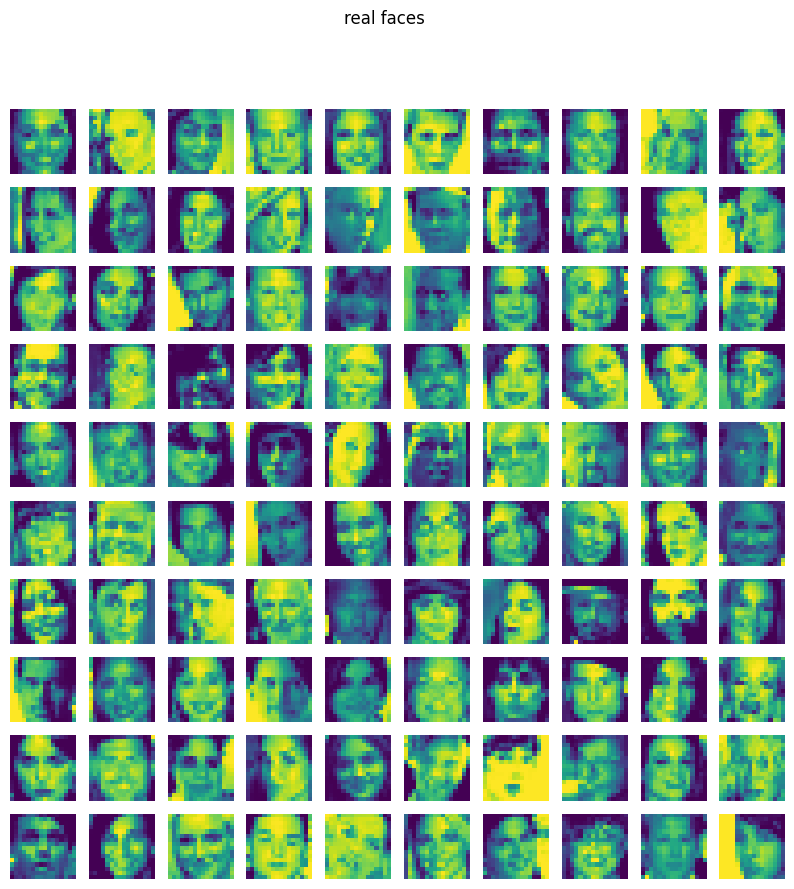

In [71]:
# load the pictures
import matplotlib.pyplot as plt
array_of_pictures=np.load("/content/drive/MyDrive/dataset/small_res_faces_10000.npy")
array_of_pictures=array_of_pictures.astype("float32")/255

fig,axes=plt.subplots(10,10,figsize=(10,10))
fig.suptitle("real faces")
for i in range(100) :
    axes[i//10,i%10].imshow(array_of_pictures[i,:,:])
    axes[i//10,i%10].axis("off")
plt.show()

Let us have a look at the mean face :

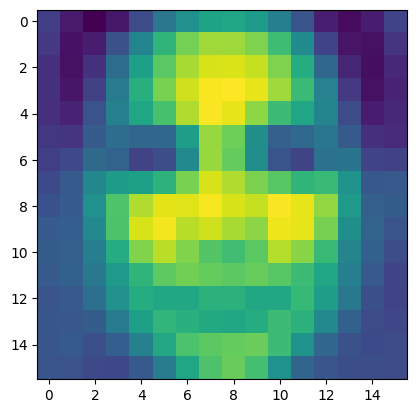

In [72]:
mean_face=array_of_pictures.mean(axis=0)
plt.imshow(mean_face)

In [73]:
centered_array = array_of_pictures - mean_face

In [74]:
multiplier=np.max(np.abs(array_of_pictures),axis=0)
normalized_array = centered_array/multiplier

In [75]:
def recover(normalized) :
    return normalized*multiplier+mean_face

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models

def convolutional_GenDiscr():

    def generator():
        model = models.Sequential()
        model.add(layers.Input(shape=(16,)))
        model.add(layers.Dense(2048, activation='tanh'))
        model.add(layers.Reshape((2, 2, 512)))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('tanh'))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(16, kernel_size=3, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('tanh'))

        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(1, kernel_size=3, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('tanh'))

        return model

    def discriminator():
        model = models.Sequential()
        model.add(layers.Input(shape=(16, 16, 1)))

        model.add(layers.Conv2D(32, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Activation('tanh'))

        model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Activation('tanh'))

        model.add(layers.Conv2D(128, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Activation('tanh'))

        model.add(layers.Conv2D(256, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Activation('tanh'))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    return generator(), discriminator()




Epoch 1/5
5/5 [==============================] - 4s 15ms/step - discr_loss: 2.7598 - gen_loss: 2.5034
Epoch 2/5
5/5 [==============================] - 0s 12ms/step - discr_loss: 1.9806 - gen_loss: 3.9796
Epoch 3/5
5/5 [==============================] - 0s 15ms/step - discr_loss: 1.8777 - gen_loss: 4.0084
Epoch 4/5
5/5 [==============================] - 0s 14ms/step - discr_loss: 1.5542 - gen_loss: 3.7823
Epoch 5/5
5/5 [==============================] - 0s 15ms/step - discr_loss: 1.8744 - gen_loss: 2.7995


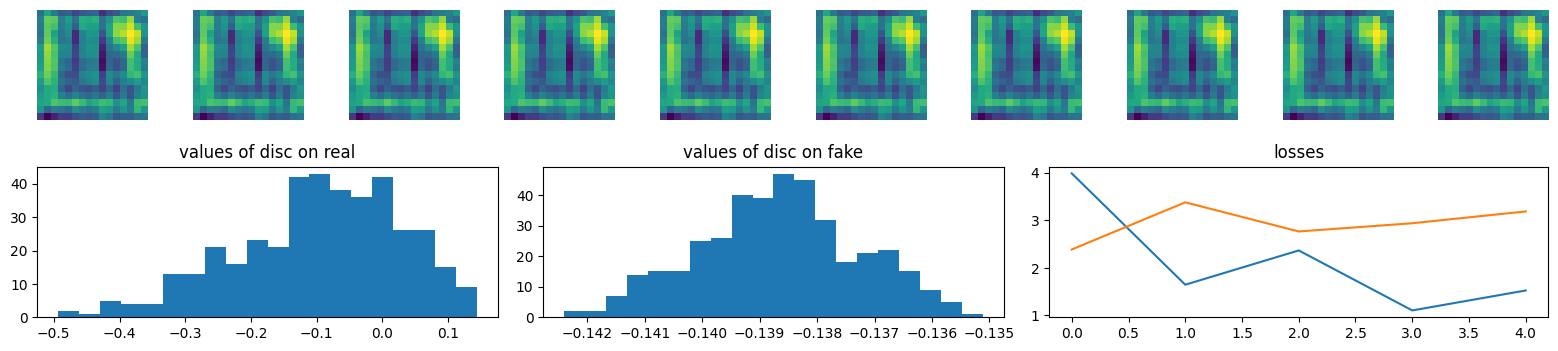

In [77]:
# MAIN 3
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def spheric_generator(nb_points, dim) :
    u=tf.random.normal(shape=(nb_points, dim))
    return u/tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(u),axis=[1])+10**-8),[nb_points,1])

## Load the pictures from small_res_faces_10000

array_of_pictures=np.load("/content/drive/MyDrive/dataset/small_res_faces_10000.npy")
array_of_pictures=array_of_pictures.astype("float32")/255

## Center and Normalize the data

mean_face=array_of_pictures.mean(axis=0)
centered_array = array_of_pictures - mean_face
multiplier=np.max(np.abs(array_of_pictures),axis=0)
normalized_array = centered_array/multiplier

## An example of a large real sample

lat_gen = lambda k : spheric_generator(k, 16)*.3+.5
real_ex = tf.convert_to_tensor(normalized_array,dtype="float32")

## Visualize the faces

def recover(normalized) :
    return normalized*multiplier+mean_face

def visualize_faces(G, lat_vecs, show_history=True):
    fig = plt.figure(figsize=(20, 4))
    wax = 4
    gs = gridspec.GridSpec(wax * 2, wax * 10)
    axes1 = [fig.add_subplot(gs[:wax - 1, i * wax:(i + 1) * wax - 1]) for i in range(10)]
    axes2 = [fig.add_subplot(gs[wax:, 0:3 * wax]), fig.add_subplot(gs[wax:, 3 * wax + 1:6 * wax + 1]),
             fig.add_subplot(gs[wax:, 6 * wax + 2:9 * wax + 3])]

    generated_images = recover(G.generator(lat_vecs))

    for i in range(10):
        axes1[i].axis("off")
        axes1[i].imshow(generated_images[i, :, :, 0])

    b = G.discriminator(G.get_fake_sample(400)).numpy()
    a = G.discriminator(G.get_real_sample(400)).numpy()
    axes2[0].hist(a, bins=20)
    axes2[0].set_title("values of disc on real")
    axes2[1].hist(b, bins=20)
    axes2[1].set_title("values of disc on fake")
    if show_history:
        axes2[2].plot(G.history.history["discr_loss"])
        axes2[2].plot(G.history.history["gen_loss"])
        axes2[2].set_title("losses")

    plt.show()

## LET'S GO !

# Train
set_seeds(0)
gen, discr = convolutional_GenDiscr()
G=Simple_GAN(gen,discr, lat_gen, real_ex, disc_iter=1, batch_size=10,learning_rate=.001)
G.compile()
G.fit(real_ex,epochs=5,steps_per_epoch=5)

# Visualize
lat_vecs = lat_gen(10)
visualize_faces(G,lat_vecs)

In [78]:
# TASK 4
import tensorflow as tf
import numpy as np

class WGAN_GP:
    def __init__(self, generator, discriminator, latent_generator, real_examples, batch_size=64, disc_iter=5, learning_rate=0.0001):
        self.generator = generator
        self.discriminator = discriminator
        self.latent_generator = latent_generator
        self.real_examples = real_examples
        self.batch_size = batch_size
        self.disc_iter = disc_iter
        self.learning_rate = learning_rate
        self.history = None

    def compile(self):
        # Define optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(self.learning_rate, beta_1=0.0, beta_2=0.9)
        self.disc_optimizer = tf.keras.optimizers.Adam(self.learning_rate, beta_1=0.0, beta_2=0.9)

        # Define loss functions
        self.gen_loss_fn = self.generator_loss
        self.disc_loss_fn = self.discriminator_loss

    def generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        return real_loss + fake_loss

    def replace_weights(self, gen_h5, disc_h5):
        self.generator.load_weights(gen_h5)
        self.discriminator.load_weights(disc_h5)

    def get_fake_sample(self, n):
        latent_samples = self.latent_generator(n)
        return self.generator(latent_samples)

    def get_real_sample(self, n):
        idx = np.random.randint(0, self.real_examples.shape[0], n)
        return self.real_examples[idx]

# Other methods related to WGAN_GP


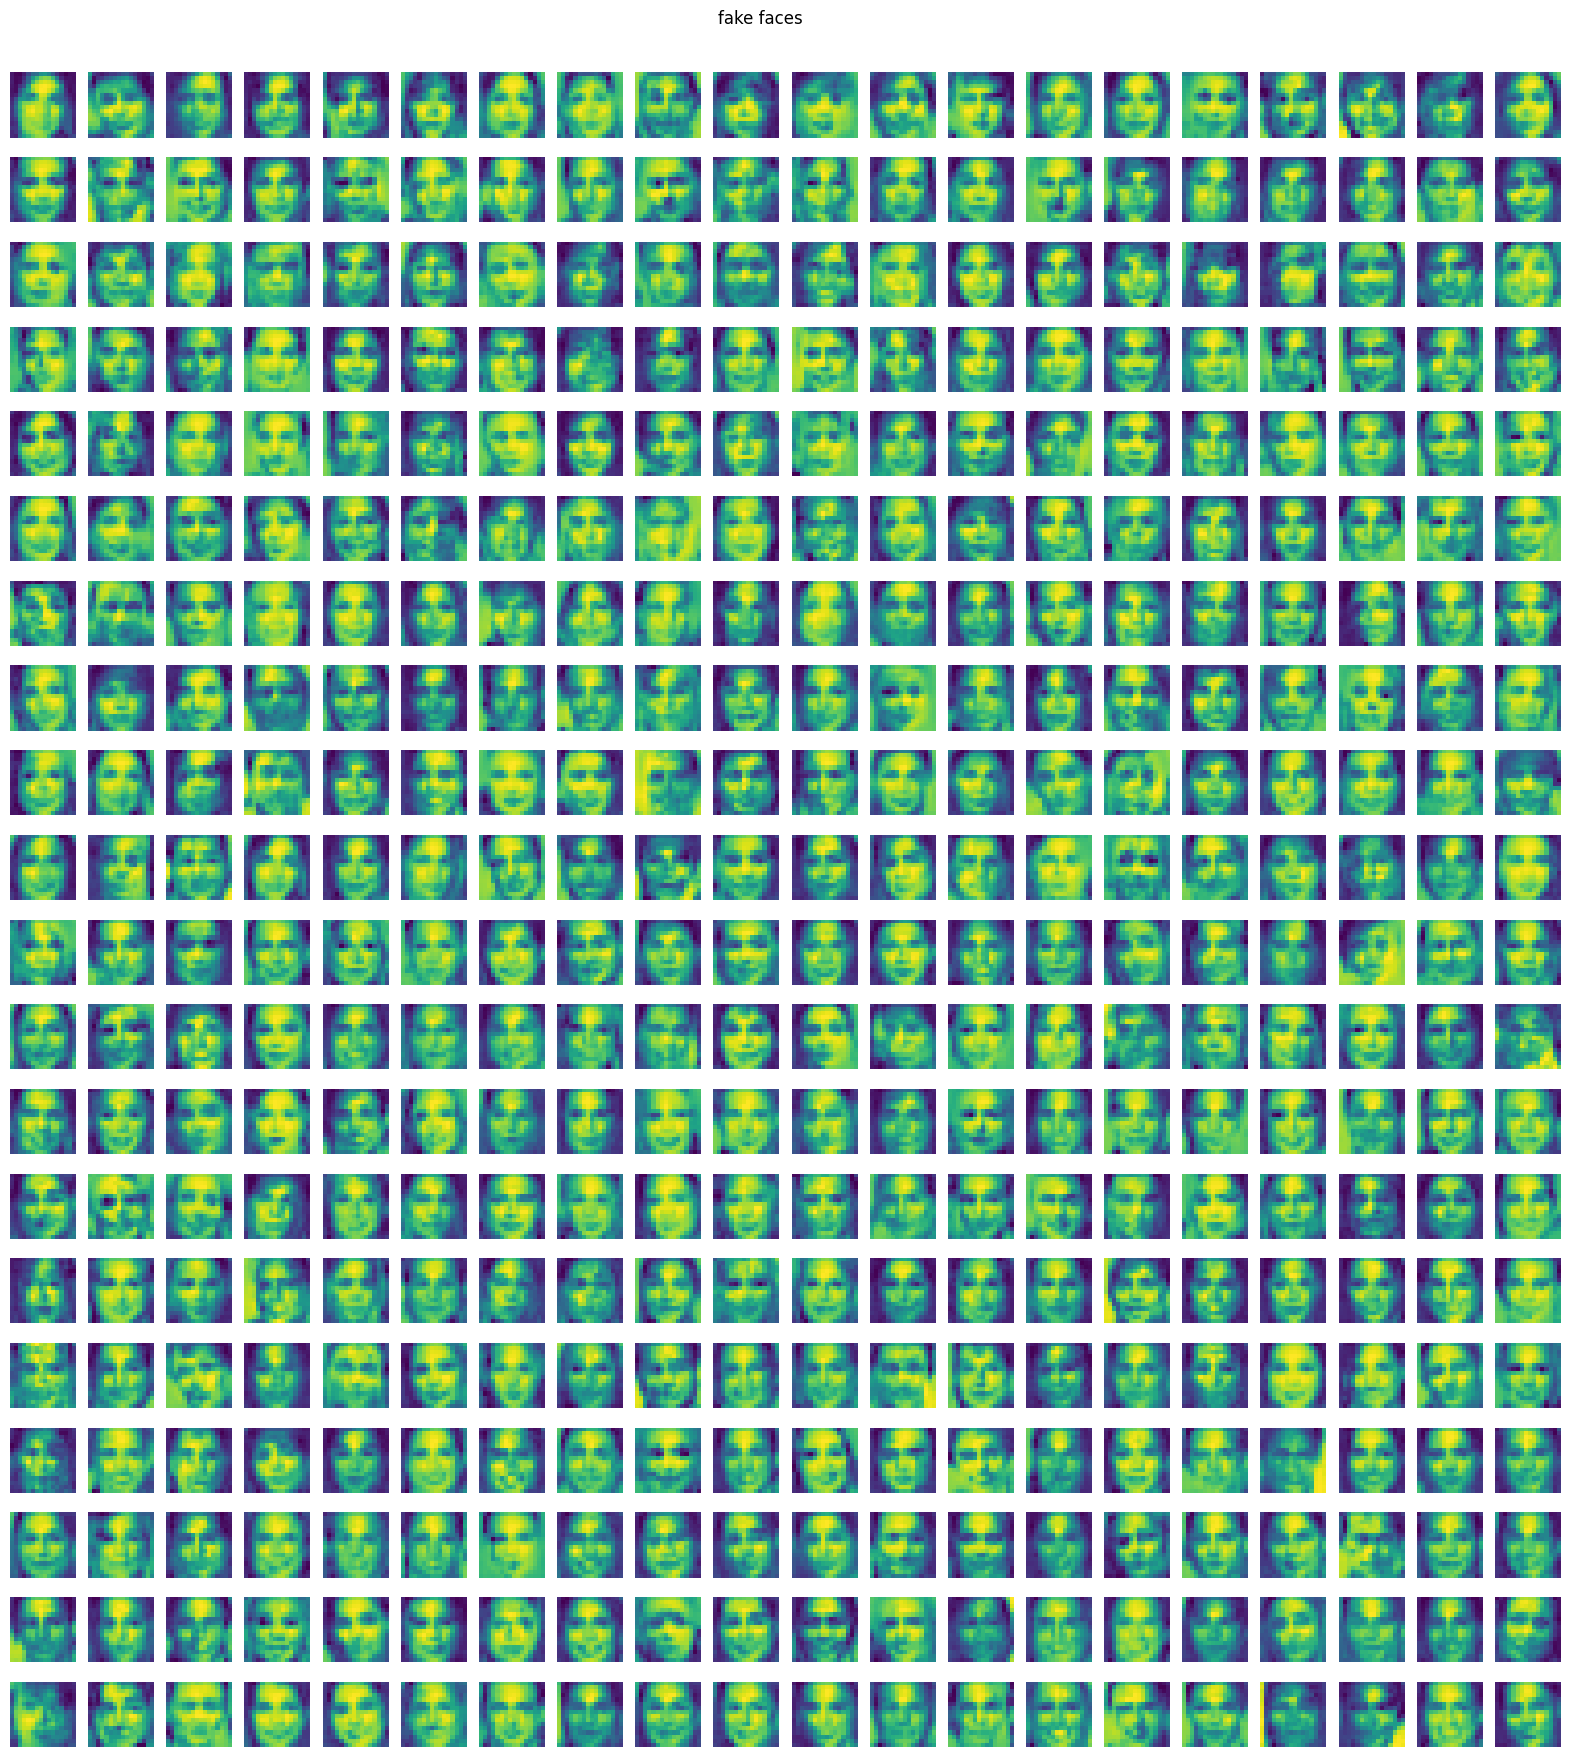

In [79]:
# MAIN 4
## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))


## Load the pictures from small_res_faces_10000

array_of_pictures=np.load("/content/drive/MyDrive/dataset/small_res_faces_10000.npy")
array_of_pictures=array_of_pictures.astype("float32")/255

## Center and Normalize the data

mean_face=array_of_pictures.mean(axis=0)
centered_array = array_of_pictures - mean_face
multiplier=np.max(np.abs(array_of_pictures),axis=0)
normalized_array = centered_array/multiplier

## An example of a large real sample

latent_generator  =  lambda k : normal_generator(k, 16)

real_ex = tf.convert_to_tensor(normalized_array,dtype="float32")

## Visualize the fake faces : Code to generate the first picture

def recover(normalized) :
    return normalized*multiplier+mean_face

def plot_400(G) :
    Y=G.get_fake_sample(400)
    Z=G.discriminator(Y)
    Znu=Z.numpy()
    Ynu=Y.numpy()
    inds=np.argsort(Znu[:,0])
    H=Ynu[inds,:,:,0]
    fig,axes=plt.subplots(20,20,figsize=(20,20))
    fig.subplots_adjust(top=0.95)
    fig.suptitle("fake faces")
    for i in range(400) :
        axes[i//20,i%20].imshow(recover(H[i,:,:]))
        axes[i//20,i%20].axis("off")
    plt.show()

## LET'S GO

set_seeds(0)
generator,discriminator = convolutional_GenDiscr()
G=WGAN_GP(generator,discriminator,latent_generator, real_ex,batch_size=200, disc_iter=2,learning_rate=.001)
G.replace_weights("/content/drive/MyDrive/dataset/generator.h5","/content/drive/MyDrive/dataset/discriminator.h5")
plot_400(G)

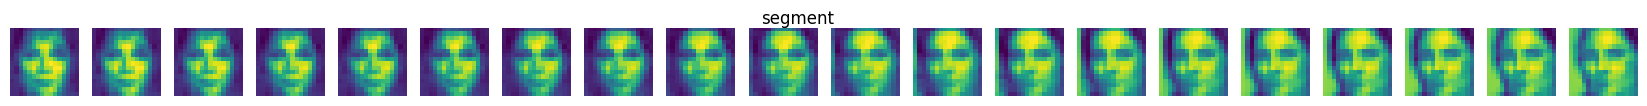

In [80]:
# MAIN 1

## Regulating the seed

def set_seeds(seed) :
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def normal_generator(nb_points, dim) :
    return tf.random.normal(shape=(nb_points, dim))


## Load the pictures from small_res_faces_10000

array_of_pictures=np.load("/content/drive/MyDrive/dataset/small_res_faces_10000.npy")
array_of_pictures=array_of_pictures.astype("float32")/255

## Center and Normalize the data

mean_face=array_of_pictures.mean(axis=0)
centered_array = array_of_pictures - mean_face
multiplier=np.max(np.abs(array_of_pictures),axis=0)
normalized_array = centered_array/multiplier

## An example of a large real sample

latent_generator  =  lambda k : normal_generator(k, 16)

real_ex = tf.convert_to_tensor(normalized_array,dtype="float32")

## Visualize the fake faces : Code to generate the first picture

def recover(normalized) :
    return normalized*multiplier+mean_face

def segment(ab,n):
    x=np.linspace(0,1,n)
    return (1-x)[:,None]*ab[0,:][None,:]+x[:,None]*ab[1,:][None,:]


def plot_segment(G,ab,n) :
    lats=tf.convert_to_tensor(segment(ab,n))
    Y=G.generator(lats)[:,:,:,0]
    fig,axes=plt.subplots(1,n,figsize=(n+1,1))
    fig.subplots_adjust(top=0.8)
    fig.suptitle("segment")
    for i in range(n) :
        axes[i].imshow(recover(Y[i,:,:]))
        axes[i].axis("off")
    plt.savefig("segment.png")
    plt.show()


## LET'S GO

set_seeds(18)
generator,discriminator = convolutional_GenDiscr()
G=WGAN_GP(generator,discriminator,latent_generator, real_ex,batch_size=200, disc_iter=2,learning_rate=.001)
G.replace_weights("/content/drive/MyDrive/dataset/generator.h5","/content/drive/MyDrive/dataset/discriminator.h5")

ab=np.random.randn(32).reshape([2,16])
plot_segment(G,ab,20)

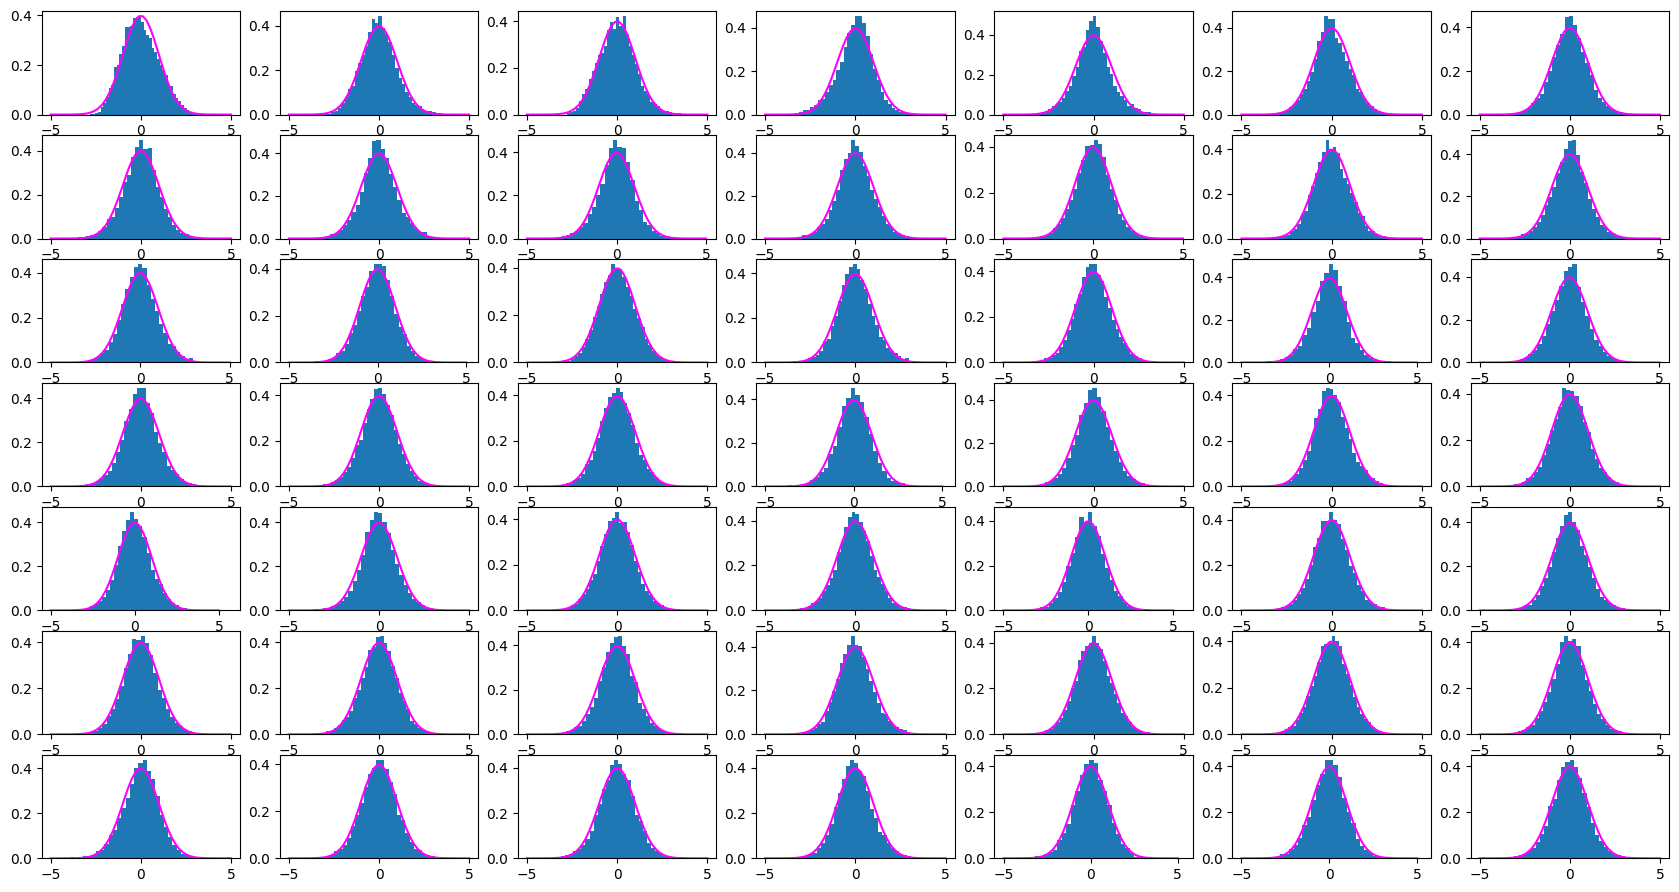

In [81]:
flat=array_of_pictures.reshape(10000,256)
from sklearn.decomposition import PCA
pca = PCA(n_components=49)
pca.fit(flat)
X=pca.transform(flat)
X/=np.std(X,axis=0)

from scipy.stats import norm
x=np.linspace(-5,5,50)
y=norm.pdf(x)

fig,axes=plt.subplots(7,7,figsize=(21,11))
for i in range(49) :
    axes[i//7,i%7].hist(X[:,i],density=True, bins=40)
    axes[i//7,i%7].plot(x,y, color="magenta")
plt.show()

In [82]:
import matplotlib.pyplot as plt

def plot_100(images, title="Generated Faces"):
    """
    Function to plot 100 images in a 10x10 grid.

    Parameters:
    - images: A numpy array or tensor of shape (100, height, width) or (100, height, width, 3) for RGB images.
    - title: Title of the plot.
    """
    assert images.shape[0] == 100, "The function expects 100 images to plot."

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title)

    for i in range(100):
        ax = axes[i // 10, i % 10]
        ax.imshow(images[i], cmap='gray' if images.shape[-1] == 1 else None)
        ax.axis('off')

    plt.show()


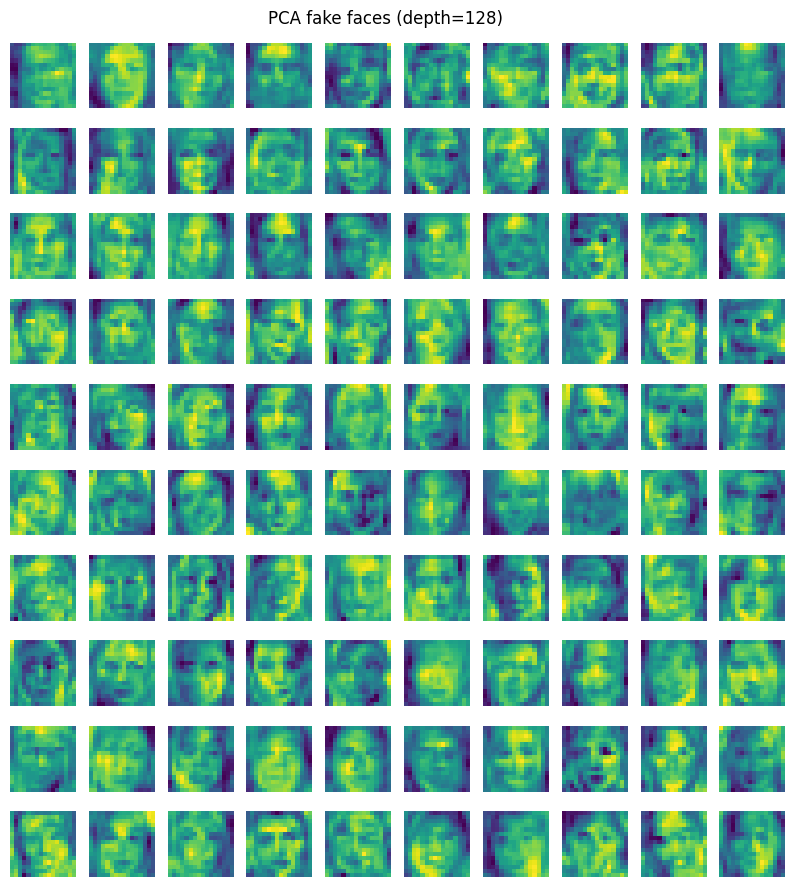

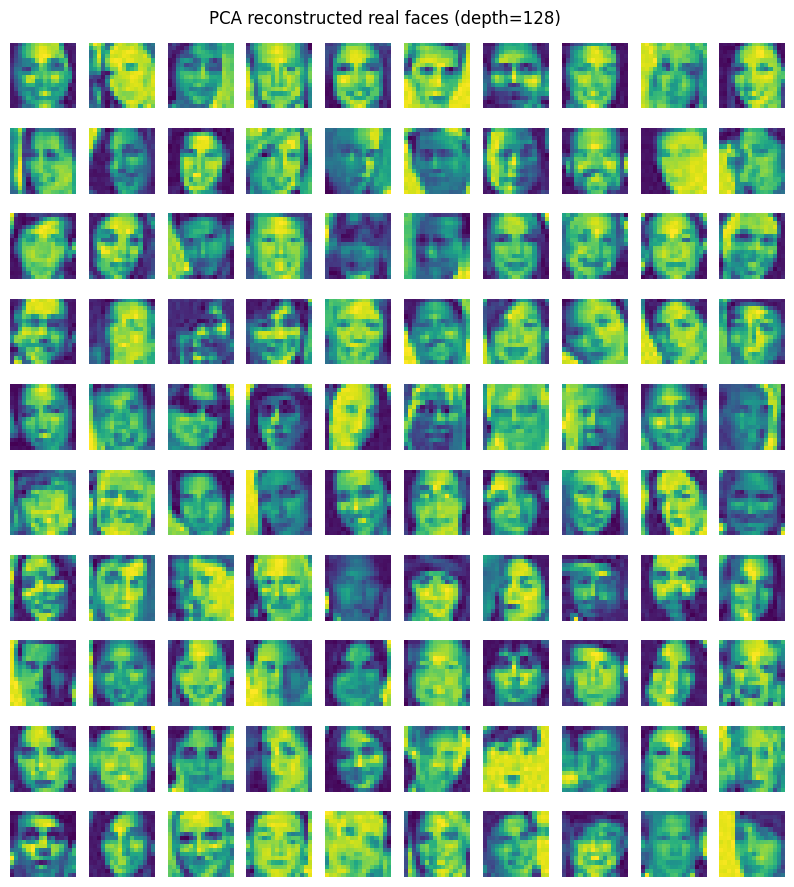

In [83]:
class PCA_generator() :
    def __init__(self,array_of_pictures,depth):
        self.arr    = array_of_pictures
        self.depth  = depth

        self.n_ims        = self.arr.shape[0]
        self.im_dims      = self.arr.shape[1:]
        self.prod_im_dims = np.prod(self.im_dims)

        self.mean_face   = self.arr.mean(axis=0)
        self.centered    = self.arr-self.mean_face
        self.flat        = self.centered.reshape(self.n_ims, self.prod_im_dims)
        self.pca         = PCA(n_components=self.depth)
        self.transformed = self.pca.fit_transform(self.flat)
        self.stds        = np.std(self.transformed,axis=0)

    def get_centered_sample_from_coords(self,coords) :
        return self.pca.inverse_transform(coords).reshape([coords.shape[0]]+list(self.im_dims))

    def get_fake_sample(self,k) :
        return self.get_centered_sample_from_coords(np.random.randn(k,self.depth)*self.stds)+self.mean_face

    def plot_100_fake(self):
        plot_100(self.get_fake_sample(100),f"PCA fake faces (depth={self.depth})")

    def plot_100_reconstructed_real(self) :
        H=self.get_centered_sample_from_coords(self.transformed[:100])+self.mean_face
        plot_100(H,f"PCA reconstructed real faces (depth={self.depth})")

array_of_pictures=np.load("/content/drive/MyDrive/dataset/small_res_faces_10000.npy")
array_of_pictures=array_of_pictures.astype("float32")/255

G=PCA_generator(array_of_pictures,128)
G.plot_100_fake()
G.plot_100_reconstructed_real()

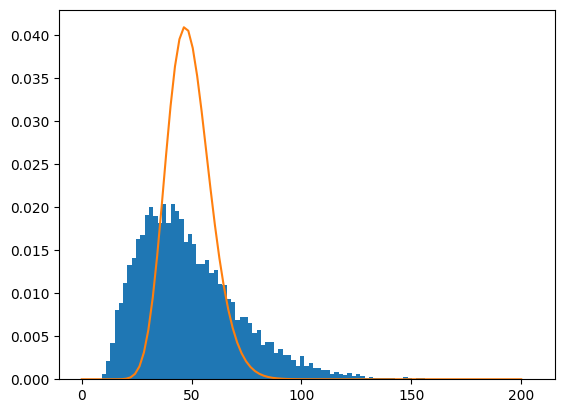

In [84]:
plt.hist(np.sum(np.square(X),axis=1),bins=100,density=True)
from scipy.stats import chi2
x=np.linspace(0,200,100)
plt.plot(x, chi2.pdf(x, 49))
plt.savefig("not_chi2.png")
plt.show()

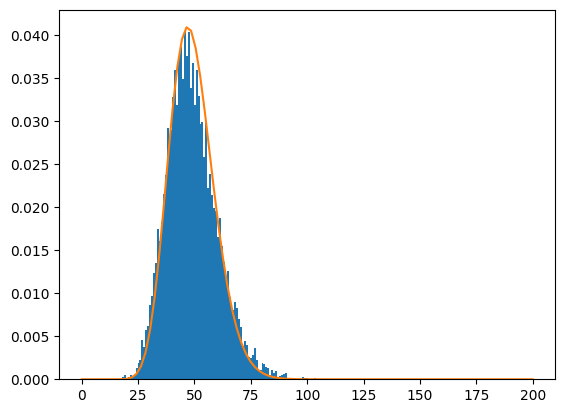

In [85]:
Y=X.copy()
for i in range(49) :
    np.random.shuffle(Y[:,i])
plt.hist(np.sum(np.square(Y),axis=1),bins=100,density=True)
from scipy.stats import chi2
x=np.linspace(0,200,100)
plt.plot(x, chi2.pdf(x, 49))
plt.savefig("chi2.png")
plt.show()